In [ ]:
!pip install -qU bertviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.5/157.5 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 127.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 75.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 kB 8.8 MB/s eta 0:00:00


In [ ]:
from __future__ import annotations

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, Subset
import numpy as np
import random
import json
import matplotlib.pyplot as plt

# クラス設定
#selected_classes = ['cat', 'dog', 'airplane', 'frog', 'truck']
selected_classes = ['cat', 'airplane', 'frog', 'truck']
class_to_idx = {
    'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4,
    'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9
}
selected_labels = [class_to_idx[c] for c in selected_classes]

# ラベルリマップ: 元ラベル -> 0～3
label_map = {orig: i for i, orig in enumerate(selected_labels)}

# データセット取得
transform = transforms.ToTensor()
dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# サブセット抽出
indices = [i for i, label in enumerate(dataset.targets) if label in selected_labels]
subset = Subset(dataset, indices)

# リマップ用ラッパー
class RemapLabels(torch.utils.data.Dataset):
    def __init__(self, subset, label_map):
        self.subset = subset
        self.label_map = label_map
    def __getitem__(self, idx):
        img, label = self.subset[idx]
        return img, self.label_map[label]
    def __len__(self):
        return len(self.subset)

filtered_dataset = RemapLabels(subset, label_map)

# train/test分割
indices = list(range(len(filtered_dataset)))
random.seed(42)
random.shuffle(indices)
split = int(len(indices) * 0.8)
train_idx, test_idx = indices[:split], indices[split:]
train_ds = torch.utils.data.Subset(filtered_dataset, train_idx)
test_ds = torch.utils.data.Subset(filtered_dataset, test_idx)

batch_size = 64
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

100%|██████████| 170M/170M [00:04<00:00, 40.5MB/s]


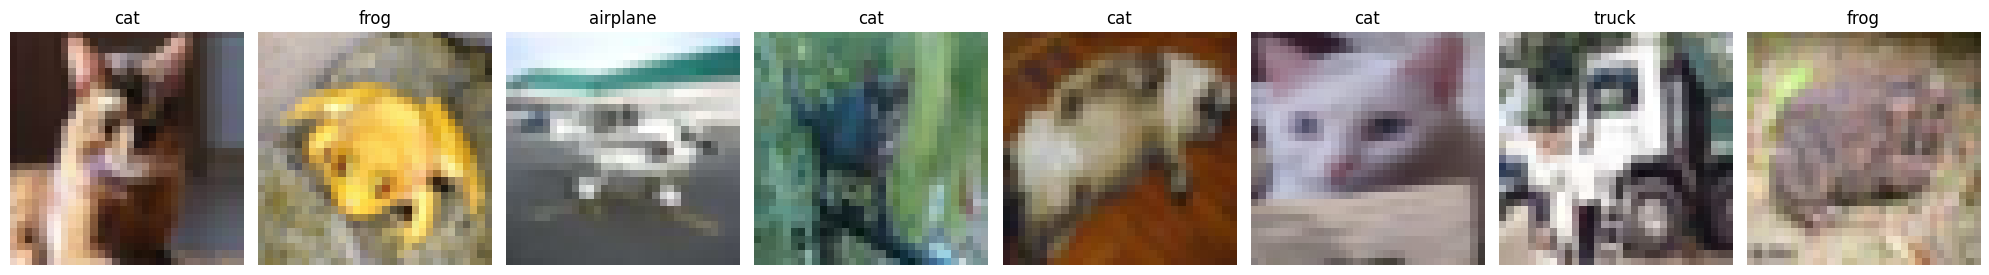

In [ ]:
# 可視化: 1バッチ分表示
images, labels = next(iter(test_loader))
class_names = selected_classes

viz_batch_size = 8

fig, axes = plt.subplots(1, viz_batch_size, figsize=(2.5*viz_batch_size, 3))
for i in range(viz_batch_size):
    img = images[i].permute(1, 2, 0).numpy()
    axes[i].imshow(img)
    axes[i].set_title(class_names[labels[i]])
    axes[i].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# 2. パッチ分割ユーティリティ
def img_to_patches(img, patch_size=4):
    # img: [C, H, W]
    C, H, W = img.shape
    assert H % patch_size == 0 and W % patch_size == 0
    patches = img.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)
    patches = patches.contiguous().view(C, -1, patch_size, patch_size)
    patches = patches.permute(1, 0, 2, 3).contiguous().view(-1, C * patch_size * patch_size)
    return patches # [num_patches, patch_dim]

# 3. 位置エンコーディング
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        if d_model > 1:
            pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)
    def forward(self, x):
        # x: [B, N, d]
        return x + self.pe[:x.size(1)]

# 4. MiniViT (MiniFormerベース)
class MiniViT(nn.Module):
    def __init__(self,
                 patch_dim,    # 3*patch*patch
                 num_patches,
                 num_classes=5,
                 d_model=64):
        super().__init__()
        self.patch_embed = nn.Linear(patch_dim, d_model)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_model))
        self.pos_enc = PositionalEncoding(d_model, num_patches+1)
        # Self-Attention (single head, 1層)
        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.attn_out = nn.Linear(d_model, d_model)
        # FFN
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Linear(d_model, d_model)
        )
        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)
        self.fc_out = nn.Linear(d_model, num_classes)
        self.attn_weights = None  # for visualization

    def forward(self, img, return_attn=False):
        # img: [B, 3, H, W]
        B = img.size(0)
        patches = torch.stack([img_to_patches(im) for im in img]) # [B, N, patch_dim]
        x = self.patch_embed(patches) # [B, N, d_model]
        # cls token
        cls_token = self.cls_token.expand(B, -1, -1) # [B, 1, d_model]
        x = torch.cat([cls_token, x], dim=1) # [B, N+1, d_model]
        x = self.pos_enc(x)
        # Attention
        Q = self.q_linear(x)
        K = self.k_linear(x)
        V = self.v_linear(x)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(Q.size(-1))
        attn = torch.softmax(scores, dim=-1)
        attn_out = torch.matmul(attn, V)
        attn_out = self.attn_out(attn_out)
        x1 = self.ln1(x + attn_out)
        x2 = self.ln2(x1 + self.ffn(x1))
        cls_out = x2[:, 0] # [B, d_model]
        logits = self.fc_out(cls_out)
        if return_attn:
            self.attn_weights = attn.detach().cpu().numpy()
            return logits, attn
        return logits

# 5. BertViz互換のAttention保存
def save_attention(attn_matrix, input_tokens, filename="attn_weights.json"):
    data = {
        "tokens": input_tokens,
        "attentions": attn_matrix.tolist()
    }
    with open(filename, "w") as f:
        json.dump(data, f, indent=2)

In [ ]:
# 6. 学習・評価
def train(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            logits = model(x)
            loss = criterion(logits, y)
            total_loss += loss.item()
            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    return total_loss / len(loader), correct / total

In [ ]:
%%time

device = "cuda" if torch.cuda.is_available() else "cpu"
patch_size = 4
num_patches = (32 // patch_size) * (32 // patch_size)
patch_dim = 3 * patch_size * patch_size
d_model = 64
n_epochs = 100

model = MiniViT(patch_dim, num_patches, num_classes=4, d_model=d_model).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

for epoch in range(1, n_epochs+1):
    train_loss = train(model, train_loader, optimizer, criterion, device)
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    print(f"Epoch {epoch:2d}: train loss={train_loss:.4f}, test loss={test_loss:.4f}, test acc={test_acc:.4f}")

# 推論＋Attention保存例
model.eval()
x, y = next(iter(test_loader))
x = x.to(device)
with torch.no_grad():
    logits, attn = model(x[:1], return_attn=True)
    pred = logits.argmax(dim=1).cpu().item()
    print(f"True: {y[0].item()}, Pred: {pred}")
    # 可視化用token名 (patch番号)
    input_tokens = ["[CLS]"] + [f"p{i}" for i in range(num_patches)]
    save_attention(attn[0], input_tokens, filename="attn_weights.json")
    print("Saved attention weights to attn_weights.json. Visualize with BertViz or similar tools.")

Epoch  1: train loss=1.1329, test loss=1.0079, test acc=0.5683
Epoch  2: train loss=0.9938, test loss=0.9656, test acc=0.6025
Epoch  3: train loss=0.9543, test loss=0.9706, test acc=0.5925
Epoch  4: train loss=0.9334, test loss=0.9198, test acc=0.6110
Epoch  5: train loss=0.9158, test loss=0.8760, test acc=0.6400
Epoch  6: train loss=0.8997, test loss=0.8785, test acc=0.6382
Epoch  7: train loss=0.9015, test loss=0.8645, test acc=0.6468
Epoch  8: train loss=0.8859, test loss=0.8651, test acc=0.6428
Epoch  9: train loss=0.8746, test loss=0.8574, test acc=0.6470
Epoch 10: train loss=0.8709, test loss=0.8625, test acc=0.6422
Epoch 11: train loss=0.8640, test loss=0.8372, test acc=0.6595
Epoch 12: train loss=0.8579, test loss=0.8527, test acc=0.6415
Epoch 13: train loss=0.8551, test loss=0.8450, test acc=0.6542
Epoch 14: train loss=0.8502, test loss=0.8381, test acc=0.6528
Epoch 15: train loss=0.8391, test loss=0.8193, test acc=0.6620
Epoch 16: train loss=0.8332, test loss=0.8384, test acc

In [ ]:
import json
import numpy as np
import torch
from bertviz import head_view

with open('attn_weights.json') as f:
    data = json.load(f)
attn = np.array(data['attentions'])  # (65, 65)
tokens = data['tokens']

# (1, 1, 65, 65) に変換し、リストで包む（レイヤー数=1のViTの場合）
attention = [torch.tensor(attn).unsqueeze(0).unsqueeze(0)]  # [ (1, 1, 65, 65) ]

print(f"attn.shape: {attn.shape}, tokens: {tokens}")
head_view(attention=attention, tokens=tokens)

attn.shape: (65, 65), tokens: ['[CLS]', 'p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62', 'p63']


<IPython.core.display.Javascript object>

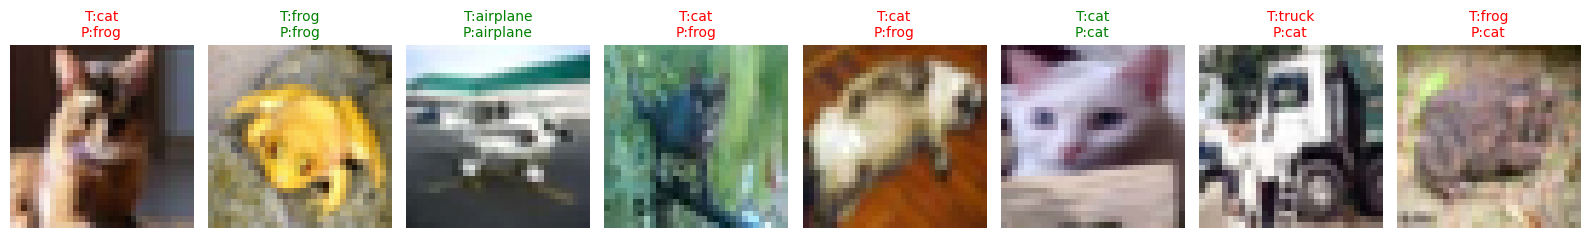

In [ ]:
import matplotlib.pyplot as plt
import torch

# モデル, test_loader, device, class_names などは既に用意されているものとします

def visualize_predictions(model, test_loader, class_names, device, num_images=8):
    model.eval()
    images_shown = 0
    fig, axes = plt.subplots(1, num_images, figsize=(num_images*2, 2.5))
    axes = axes if num_images > 1 else [axes]

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = outputs.max(1)
            for i in range(images.size(0)):
                if images_shown >= num_images:
                    break
                ax = axes[images_shown]
                img = images[i].cpu()
                # 画像変換（例：0-1スケールに戻す）
                img = img.permute(1, 2, 0).numpy()
                img = (img - img.min()) / (img.max() - img.min())
                ax.imshow(img)
                ax.axis('off')
                true_label = class_names[labels[i].item()]
                pred_label = class_names[preds[i].item()]
                color = 'green' if true_label == pred_label else 'red'
                ax.set_title(f"T:{true_label}\nP:{pred_label}", color=color, fontsize=10)
                images_shown += 1
            if images_shown >= num_images:
                break
    plt.tight_layout()
    plt.show()

# 例：class_names = ['cat', 'airplane', 'frog', 'truck']
visualize_predictions(model, test_loader, class_names, device, num_images=8)

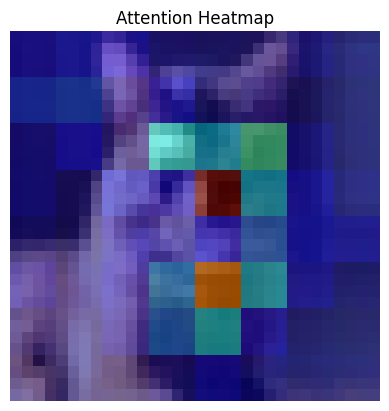

True label: 0, Pred label: 2


In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def show_attention_on_image(img, attn_map, patch_size=4):
    # img: [3, 32, 32] (CIFAR-10)
    # attn_map: [n_patches] (64次元)
    img = img.cpu()
    attn_map = attn_map.cpu().numpy()
    # パッチを画像サイズに展開
    n_patches = attn_map.shape[0]
    grid_size = int(np.sqrt(n_patches))  # 8
    attn_map_2d = attn_map.reshape(grid_size, grid_size)
    # パッチごとに拡大
    attn_map_up = np.kron(attn_map_2d, np.ones((patch_size, patch_size)))
    # 端数処理
    attn_map_up = attn_map_up[:img.shape[1], :img.shape[2]]
    # 画像のスケール調整
    img_np = img.permute(1,2,0).numpy()
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())
    plt.imshow(img_np)
    plt.imshow(attn_map_up, cmap='jet', alpha=0.5)
    plt.axis('off')
    plt.title("Attention Heatmap")
    plt.show()

# 推論・可視化例
idx = 0
model.eval()
x, y = next(iter(test_loader))
x = x.to(device)
with torch.no_grad():
    logits, attn = model(x[idx:idx+1], return_attn=True)
    pred = logits.argmax(dim=1).item()
    # [CLS]トークンから各パッチへのアテンション（1ヘッド分）
    #attn_map = torch.from_numpy(attn[0, 0, 1:])  # 64次元
    attn_map = attn[0, 0, 1:]  # 64次元Tensor
    show_attention_on_image(x[idx], attn_map, patch_size=4)
    print(f"True label: {y[0].item()}, Pred label: {pred}")

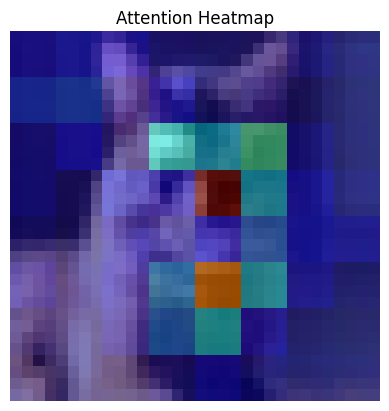

True label: 0, Pred label: 2


In [ ]:
idx = 0

# 訓練していない場合。
#model1 = MiniViT(patch_dim, num_patches, num_classes=4, d_model=d_model).to(device)
model.eval()
x, y = next(iter(test_loader))
x = x.to(device)
with torch.no_grad():
    logits, attn = model(x[idx:idx+1], return_attn=True)
    pred = logits.argmax(dim=1).item()
    # [CLS]トークンから各パッチへのアテンション（1ヘッド分）
    #attn_map = torch.from_numpy(attn[0, 0, 1:])  # 64次元
    attn_map = attn[0, 0, 1:]  # 64次元Tensor
    show_attention_on_image(x[idx], attn_map, patch_size=4)
    print(f"True label: {y[0].item()}, Pred label: {pred}")